In [1]:
import cv2
import torch
import h5py
import numpy as np
import imageio
from tqdm import tqdm, tqdm_notebook
import matplotlib.pyplot as plt
import time
from collections import defaultdict

%matplotlib inline
plt.rcParams["figure.figsize"] = (10.0, 8.0) # set default size of plots
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"

%load_ext autoreload
%autoreload 2

In [2]:
%reload_ext autoreload

from sketch2code.data_model import *
from sketch2code.datasets import *
from sketch2code.helpers import *
from sketch2code.synthesize_program import *
from sketch2code.methods.lstm import *
from sketch2code.methods.baseline1_supervised import *
from s06_supervise_baseline import *
from s01_toy_img_feature import make_vocab as make_img_vocab

/home/rook/.local/share/virtualenvs/sketch2code-rS5pvLAN/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


### Purpose

Supervised for program synthesis

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

#examples 1750


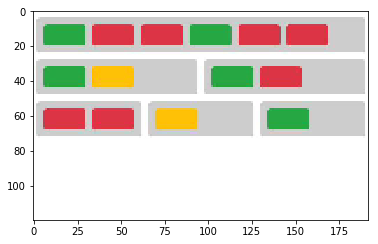

In [4]:
tags, oimages = load_dataset("toy")
print("#examples", len(tags))

def preprocess_img():
    global oimages
    return [shrink_img(img, 0.4, cv2.INTER_NEAREST).transpose((2, 0, 1)) for img in norm_rgb_imgs(oimages[:])]

images = cache_arrays("toy.shrink.imgs", preprocess_img)
plt.imshow(1 - images[0].transpose(1, 2, 0))
images = torch.tensor(images, device=device)

### Prepare datasets

In [5]:
vocab, ivocab = make_toy_vocab()
min_length = 10

def get_datasets():
    train_examples = make_dataset(tags[:1250], vocab, min_length)
    valid_examples = make_dataset(tags[1250:1500], vocab, min_length)
    test_examples = make_dataset(tags[1500:], vocab, min_length)

    return train_examples, valid_examples, test_examples

train_examples, valid_examples, test_examples = get_datasets()

#examples 1250
#examples 250
#examples 250


### Define the model

In [6]:
decoder_lr=4e-4
encoder_lr=1e-4
fine_tune_encoder=True

decoder = DecoderWithAttention(attention_dim=512,
                                       embed_dim=512,
                                       decoder_dim=512,
                                       vocab_size=len(vocab),
                                       dropout=0.5)
decoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, decoder.parameters()),
                                     lr=decoder_lr)
encoder = Encoder()
encoder.fine_tune(fine_tune_encoder)
encoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, encoder.parameters()),
                                     lr=encoder_lr) if fine_tune_encoder else None
decoder = decoder.to(device)
encoder = encoder.to(device)
criterion = nn.CrossEntropyLoss().to(device)

In [29]:
validate(encoder, decoder, criterion, 32, device)

Validation: [0/250]	Batch Time 0.271 (0.271)	Loss 1.6318 (1.6318)	Top-5 Accuracy 61.415 (61.415)	

 * LOSS - 1.635, TOP-5 ACCURACY - 61.283, BLEU-4 - 0.0



0.0

In [30]:
for i in range(4, 10):
    train2(encoder, decoder, criterion, encoder_optimizer, decoder_optimizer, i, 32, images, train_examples, device)




Epoch: [4][0/100]	Batch Time 0.710 (0.710)	Data Load Time 0.007 (0.007)	Loss 1.7577 (1.7577)	Top-5 Accuracy 59.609 (59.609)
Epoch: [4][10/100]	Batch Time 0.718 (0.730)	Data Load Time 0.002 (0.002)	Loss 1.4948 (1.5803)	Top-5 Accuracy 68.047 (65.106)
Epoch: [4][20/100]	Batch Time 0.749 (0.734)	Data Load Time 0.002 (0.002)	Loss 1.7374 (1.6679)	Top-5 Accuracy 58.699 (62.019)
Epoch: [4][30/100]	Batch Time 0.755 (0.741)	Data Load Time 0.002 (0.002)	Loss 1.7430 (1.6687)	Top-5 Accuracy 58.275 (61.852)
Epoch: [5][0/100]	Batch Time 0.710 (0.710)	Data Load Time 0.002 (0.002)	Loss 1.7749 (1.7749)	Top-5 Accuracy 58.228 (58.228)
Epoch: [5][10/100]	Batch Time 0.701 (0.726)	Data Load Time 0.001 (0.002)	Loss 1.6840 (1.6611)	Top-5 Accuracy 60.989 (61.854)
Epoch: [5][20/100]	Batch Time 0.699 (0.732)	Data Load Time 0.002 (0.002)	Loss 1.4986 (1.6182)	Top-5 Accuracy 69.393 (63.396)
Epoch: [5][30/100]	Batch Time 0.728 (0.743)	Data Load Time 0.002 (0.002)	Loss 1.7835 (1.6148)	Top-5 Accuracy 58.237 (63.313)
Ep

In [26]:
def validate(encoder, decoder, criterion, batch_size, device):
    """
    Performs one epoch's validation.
    :param val_loader: DataLoader for validation data.
    :param encoder: encoder model
    :param decoder: decoder model
    :param criterion: loss layer
    :return: BLEU-4 score
    """
    decoder.eval()  # eval mode (no dropout or batchnorm)
    if encoder is not None:
        encoder.eval()
    
    alpha_c = 1.
    batch_time = AverageMeter()
    losses = AverageMeter()
    top5accs = AverageMeter()

    start = time.time()

    references = list()  # references (true captions) for calculating BLEU-4 score
    hypotheses = list()  # hypotheses (predictions)

    # explicitly disable gradient calculation to avoid CUDA memory error
    # solves the issue #57
    with torch.no_grad():
        # Batches
#         for i, (imgs, caps, caplens, allcaps) in enumerate(val_loader):
        for i, (bimgs, bx, bnts, bxlen, bnt, bnbtn, bnrow) in enumerate(iter_batch(
            batch_size, images, valid_examples, shuffle=True, device=device)):
            # Move to device, if available

            # Forward prop.
            if encoder is not None:
                bimgs = encoder(bimgs)
            scores, caps_sorted, decode_lengths, alphas, sort_ind = decoder(bimgs, bx, bxlen, device)

            # Since we decoded starting with <start>, the targets are all words after <start>, up to <end>
            targets = bnts

            # Remove timesteps that we didn't decode at, or are pads
            # pack_padded_sequence is an easy trick to do this
            scores_copy = scores.clone()
            scores, _ = pack_padded_sequence(scores, decode_lengths, batch_first=True)
            targets, _ = pack_padded_sequence(targets, decode_lengths, batch_first=True)

            # Calculate loss
            loss = criterion(scores, targets)

            # Add doubly stochastic attention regularization
            loss += alpha_c * ((1. - alphas.sum(dim=1)) ** 2).mean()

            # Keep track of metrics
            losses.update(loss.item(), sum(decode_lengths))
            top5 = accuracy(scores, targets, 1)
            top5accs.update(top5, sum(decode_lengths))
            batch_time.update(time.time() - start)

            start = time.time()

            if i % 10 == 0:
                print('Validation: [{0}/{1}]\t'
                      'Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                      'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                      'Top-5 Accuracy {top5.val:.3f} ({top5.avg:.3f})\t'.format(i, len(valid_examples), batch_time=batch_time,
                                                                                loss=losses, top5=top5accs))

            # Store references (true captions), and hypothesis (prediction) for each image
            # If for n images, we have n hypotheses, and references a, b, c... for each image, we need -
            # references = [[ref1a, ref1b, ref1c], [ref2a, ref2b], ...], hypotheses = [hyp1, hyp2, ...]

            # References
#             allcaps = allcaps[sort_ind]  # because images were sorted in the decoder
#             for j in range(allcaps.shape[0]):
#                 img_caps = allcaps[j].tolist()
#                 img_captions = list(
#                     map(lambda c: [w for w in c if w not in {word_map['<program>'], word_map['<pad>']}],
#                         img_caps))  # remove <start> and pads
#                 references.append(img_captions)

#             # Hypotheses
#             _, preds = torch.max(scores_copy, dim=2)
#             preds = preds.tolist()
#             temp_preds = list()
#             for j, p in enumerate(preds):
#                 temp_preds.append(preds[j][:decode_lengths[j]])  # remove pads
#             preds = temp_preds
#             hypotheses.extend(preds)

#             assert len(references) == len(hypotheses)

        # Calculate BLEU-4 scores
#         bleu4 = corpus_bleu(references, hypotheses)
        bleu4 = 0.0
        print(
            '\n * LOSS - {loss.avg:.3f}, TOP-5 ACCURACY - {top5.avg:.3f}, BLEU-4 - {bleu}\n'.format(
                loss=losses,
                top5=top5accs,
                bleu=bleu4))

    return bleu4

In [8]:
model = BLSuper5(img_h=120, img_w=192, img_repr_size=1024, dsl_vocab=vocab, dsl_embedding_dim=100, dsl_hidden_dim=512).to(device)
print(model.train())

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, amsgrad=True)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.3)

histories = train(model, scheduler, optimizer, images, (train_examples, valid_examples, test_examples), n_epoches=40, eval_test_freq=5, batch_size=100, device=device)

BLSuper5(
  (conv1): Conv2d(3, 16, kernel_size=(7, 7), stride=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=12160, out_features=1024, bias=True)
  (bn4): BatchNorm2d(1024, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
  (word_embedding): Embedding(15, 100, padding_idx=0)
  (lstm): LSTMNoEmbedding(
    (lstm): LSTM(1124, 512, batch_first=True)


#### Evaluate

In [17]:
cpu_device = torch.device('cpu')

In [21]:
checkpoint = torch.load("/home/rook/workspace/CSCI559/Project/sketch2code/runs/s05_exp/run_23/model.bin")
model2 = BLSuper5(img_h=150, img_w=240, img_repr_size=300, dsl_vocab=vocab, dsl_embedding_dim=100, dsl_hidden_dim=400)
model2.load_state_dict(checkpoint['model'])
eval(model2.to(device), images, valid_examples, device)

{'loss': 0.3753992021083832, 'accuracy': 0.8068370394955194}

In [9]:
render_engine = RemoteRenderEngine.get_instance(tags[0].to_html(), 480, 300)

In [26]:
model2 = model2.to(cpu_device)

In [31]:
next_token_func = wrap_next_token_func(lambda bimgs, bx, bxlen: model2(bimgs, bx, bxlen))
results = synthesize(images[0].to(cpu_device), oimages[0], render_engine, ivocab, vocab, next_token_func, max_unexamined_program=3, top_k=5, beam_width=500, max_depth=50)

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 0
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 1
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 2
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 3
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 4
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 5
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 6
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 7
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 8
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 9
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 10
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 11
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 12
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 13
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 14
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 15
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 16
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 17
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 18
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 19
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

0.8461875
['<program>', '<div class="container-fluid">', '<div class="row">', '<div class="col-3">', '<div class="grey-background">', '<button class="btn btn-danger">', '</button>', '</div>', '</div>', '<div class="col-3">', '<div class="grey-background">', '<button class="btn btn-danger">', '</button>', '</div>', '</div>', '<div class="col-3">', '<div class="grey-background">', '<button class="btn btn-warning">', '</button>', '</div>', '</div>', '<div class="col-3">', '<div class="grey-background">', '<button class="btn btn-success">', '</button>', '</div>', '</div>', '</div>', '<div class="row">', '<div class="col-3">', '<div class="grey-background">', '<button class="btn btn-danger">', '</button>', '</div>', '</div>', '<div class="col-3">', '<div class="grey-background">', '<button class="btn btn-danger">', '</button>', '</div>', '</div>', '<div class="col-3">', '<div class="grey-background">', '<button class="btn btn-danger">', '</button>', '</div>', '</div>', '<div class="col-3">'

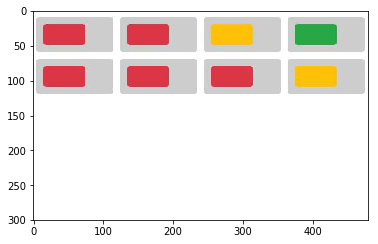

In [32]:
print(results[0].quality)
print([ivocab[w] for w in results[0].to_int_tokens(vocab)])
plt.imshow(results[0].render_img(render_engine))

In [11]:
ivocab

{0: '<pad>',
 1: '<program>',
 2: '</program>',
 3: '<div class="row">',
 4: '<div class="col-12">',
 5: '<div class="col-6">',
 6: '<div class="col-4">',
 7: '<div class="col-3">',
 8: '<div class="container-fluid">',
 9: '<div class="grey-background">',
 10: '</div>',
 11: '<button class="btn btn-danger">',
 12: '<button class="btn btn-warning">',
 13: '<button class="btn btn-success">',
 14: '</button>'}

#### DEBUG the program

Printing the image and allowing to discover next tags from the current program

['<program>', '<div class="container-fluid">', '<div class="row">', '<div class="col-4">', '<div class="grey-background">']
token_idx | next_token_str                                    | prob
       12 | <button class="btn btn-warning">                  | 0.36612
       13 | <button class="btn btn-success">                  | 0.32509
       11 | <button class="btn btn-danger">                   | 0.30744
        9 | <div class="grey-background">                     | 0.00032
       14 | </button>                                         | 0.00023
        4 | <div class="col-12">                              | 0.00023
        6 | <div class="col-4">                               | 0.00018
        5 | <div class="col-6">                               | 0.00009
       10 | </div>                                            | 0.00007
        2 | </program>                                        | 0.00006
        7 | <div class="col-3">                               | 0.00005
        8 | <di

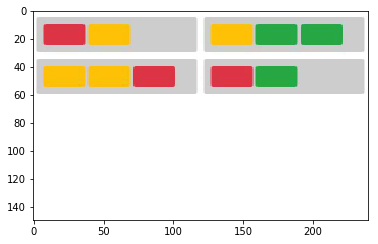

In [37]:
plt.imshow(1 - images[0].clone().detach().cpu().numpy().transpose(1, 2, 0))
program = HTMLProgram.from_int_tokens([1, 8, 3, 6, 9], ivocab)
print([ivocab[w] for w in program.to_int_tokens(vocab)])

program.print_next_tags(images[0], next_token_func, ivocab, vocab, device)

In [14]:
program = HTMLProgram.from_int_tokens([8, 3, 5, 9, 11], ivocab)
tag = program.to_linearized_tag()

In [119]:
gui = render_engine.render_page(tag)

In [120]:
gui = shrink_img(gui, 0.5)

In [121]:
gui.shape

(150, 240, 3)

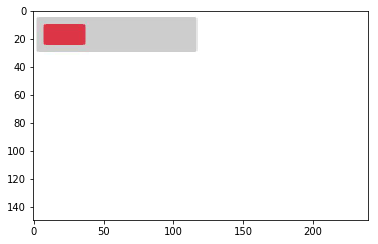

In [122]:
plt.imshow(gui)

In [123]:
ogui = shrink_img(oimages[0], 0.5)

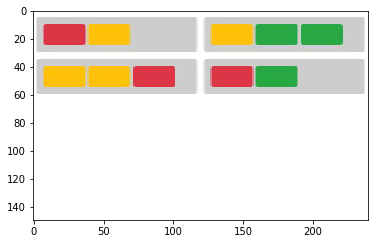

In [124]:
plt.imshow(ogui)

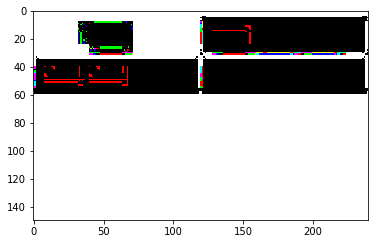

In [125]:
plt.imshow((gui == ogui).astype(np.float))

In [126]:
(gui == ogui).sum()

78933